In [53]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.1em; line-height: 140%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [78]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import seaborn as sb
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

# Actividad: Clasificación de SPAM

¿Podemos clasificar un email como spam con árboles y/o ensambles?

Usaremos la base de datos [UCI Spam database](https://archive.ics.uci.edu/ml/datasets/Spambase)

Responda las preguntas y realice las actividades en cada uno de los bloques

Entregas al correo phuijse@inf.uach.cl hasta el Viernes 13, 11:20 AM

Se trabajará en grupos de dos personas: se entrega un notebook completo por grupo

In [ ]:
# Descargar la base de datos con wget, si usas windows usa el link de arriba
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
!head -n 5 spambase.data

**Responda**
- ¿Cuántos atributos tiene la base de datos? Describalos de forma muy breve
-  Muestre un histograma de las etiquetas ¿Cuántos ejemplos hay de cada clase? ¿Es la base de datos balanceada?
- ¿Hay valores perdidos o invalidas? 

In [1]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = np.genfromtxt('spambase.data', delimiter=',')
X, Y = data[:, :-1], data[:, -1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.75, stratify=Y)

In [ ]:
df = pd.DataFrame(data)  

**Respuesta 1**
-
La tabla tiene 57 atributos y el identificador para saber si es spam o no. Hay 48 atributos en que cada uno corresponde a una palabra, el atributo toma un valor real entre 0 y 100 para representar el porcentaje de ocurrencia de la palabra en el correo.Hay otros 6 atributos en que cada uno corresponde a un caracter, el atributo toma un valor real entre 0 y 100 para representar el porcentaje de ocurrencia del caracter en el correo. Existe también un atributo es el promedio del largo de una secuencia de letras en mayuscula y otro para la secuencia de letras mayusculas más larga. Además hay uno que cuenta todas las letras mayusculas en el correo. Y por último tenemos el identificador del correo, nos dice si es spam o no.

<IPython.core.display.Javascript object>


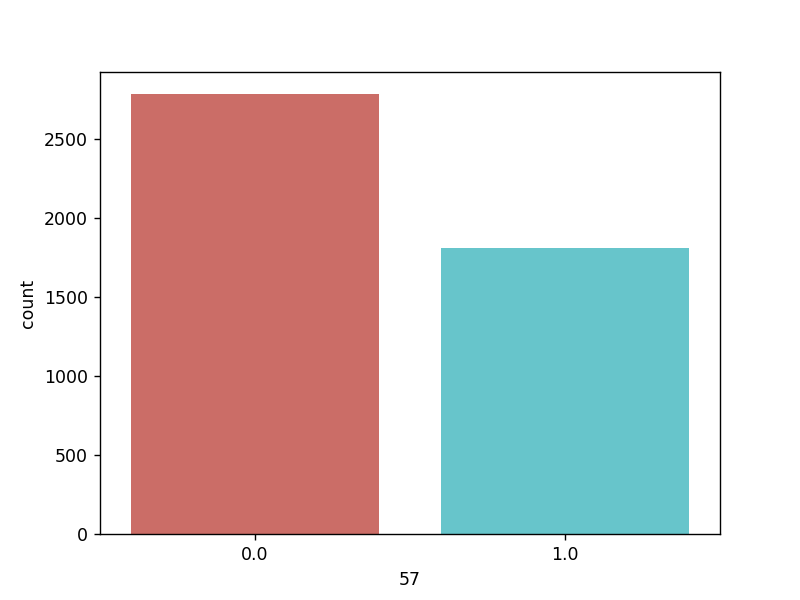

0.0    2788
1.0    1813
Name: 57, dtype: int64

In [44]:
sb.countplot(x=57, data=df, palette='hls')
df[57].value_counts()

**Respuesta 2**
-
Existen 2788 datos que están etiqutados como no-spam y 1813 que pertenecer a la clase spam. Por otro lado, podría decirse que la base de datos está medianamente balanceada ya que la diferencia de cantidad de muestras entre ambas clases no es extremadamente desequilibrada

In [ ]:
df.isnull().sum()

**Respuesta 3**
-
No existen valores nulos en ningun atributo de la base de datos.

---
---

Use el conjunto de entrenamiento para entrenar y ajustar los parámetros de un 
1. árbol de decisión
1. ensamble random forest 
1. ensamble *gradient boosting*

Puede usar `GridSearchCV` para encontrar los mejores estimadores

Para este caso particular y para cada estimador responda
- ¿Qué función/criterio funciona mejor? `criterion`
- ¿Qué profundidad de árbol funciona mejor? `max_depth`
- ¿Combiene ponderar las clases? `class_weight`
- En el caso de los ensambles 
    - ¿Es recomendable usar un subconjunto aleatorio de características? `max_features`
    - ¿Cuál es la mejor cantidad de clasificadores débiles? `n_estimators`

Compare los mejores modelos de cada tipo en el conjunto de test usando métricas de clasificación apropiadas

Analice y comente sus resultados

In [114]:
#ARBOL DE DECISION

params = {'criterion':('entropy', 'gini'), 'max_depth':[14, 16, 18, 20, 22, 24, 26]}
model = tree.DecisionTreeClassifier()
clf_dt = GridSearchCV(model, params, cv=5)
clf_dt.fit(X_train, Y_train)
display(clf_dt.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=18,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

<IPython.core.display.Javascript object>


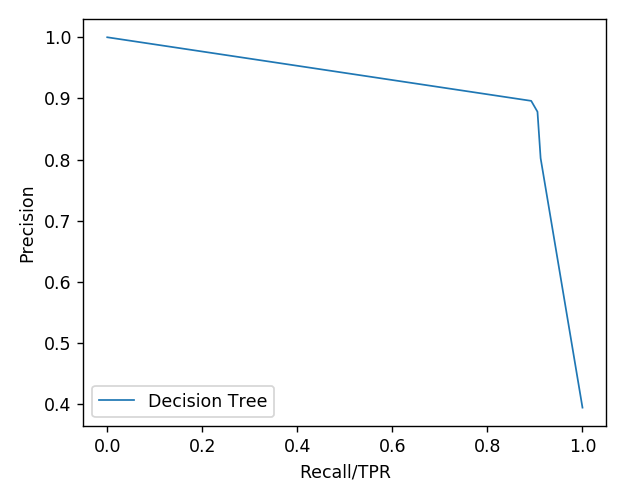

In [115]:
fig, ax = plt.subplots(1, figsize=(5, 4), tight_layout=True)
ax.set_xlabel('Recall/TPR')
ax.set_ylabel('Precision')

Y_pred = clf_dt.best_estimator_.predict_proba(X_test)[:, 1]
precision, recall, th = precision_recall_curve(Y_test, Y_pred)
ax.plot(recall, precision, label="Decision Tree", linewidth=1)

plt.legend(loc=3);

In [120]:
#MUESTRA DE RESULTADOS USANDO ENTROPY Y GINI PARA DISTINTAS PROFUNDIDADES DE ARBOL

# Crear kfold generator
fold_generator = KFold(n_splits=5)
# para cada profundidad
for max_depth in [14, 16, 18, 20, 22, 24, 26]: 
    # crear un modelo
    model = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=max_depth)
    # crear 5 splits
    score = np.zeros(shape=(5, ))
    for fold_index, (train_index, valid_index) in enumerate(fold_generator.split(X_train)):
        # entrenar en 4 folds
        model.fit(X_train[train_index], Y_train[train_index])
        # validar en 1 fold
        score[fold_index] = model.score(X_train[valid_index], Y_train[valid_index])
    # mostrar promedio y desviación estándar de la loss
    print("profundidad %d:\tloss validación: %f +/- %f   ENTROPY" % (max_depth, np.mean(score), np.std(score)))
    
    model = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                        max_depth=max_depth)
    # crear 5 splits
    score = np.zeros(shape=(5, ))
    for fold_index, (train_index, valid_index) in enumerate(fold_generator.split(X_train)):
        # entrenar en 4 folds
        model.fit(X_train[train_index], Y_train[train_index])
        # validar en 1 fold
        score[fold_index] = model.score(X_train[valid_index], Y_train[valid_index])
    # mostrar promedio y desviación estándar de la loss
    print("profundidad %d:\tloss validación: %f +/- %f   GINI" % (max_depth, np.mean(score), np.std(score)) + " \n")

profundidad 14:	loss validación: 0.917391 +/- 0.007159   ENTROPY
profundidad 14:	loss validación: 0.913623 +/- 0.010713   GINI 

profundidad 16:	loss validación: 0.917101 +/- 0.004037   ENTROPY
profundidad 16:	loss validación: 0.914493 +/- 0.007614   GINI 

profundidad 18:	loss validación: 0.919420 +/- 0.004453   ENTROPY
profundidad 18:	loss validación: 0.911014 +/- 0.010394   GINI 

profundidad 20:	loss validación: 0.915942 +/- 0.009302   ENTROPY
profundidad 20:	loss validación: 0.914783 +/- 0.006698   GINI 

profundidad 22:	loss validación: 0.915362 +/- 0.005620   ENTROPY
profundidad 22:	loss validación: 0.907246 +/- 0.011338   GINI 

profundidad 24:	loss validación: 0.915652 +/- 0.005606   ENTROPY
profundidad 24:	loss validación: 0.907536 +/- 0.008763   GINI 

profundidad 26:	loss validación: 0.915942 +/- 0.006673   ENTROPY
profundidad 26:	loss validación: 0.910435 +/- 0.006571   GINI 



In [118]:
from sklearn.metrics import roc_curve, auc
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5), tight_layout=True)

print("Entrenamiento: %f" % (model.score(X_train, Y_train)))
print("Validación: %f" % (model.score(X_test, Y_test)))

ax[0].contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.5)
ax[0].scatter(X[Y==0, 0], X[Y==0, 1], color='k', s=10, marker='o', alpha=0.5)
ax[0].scatter(X[Y==1, 0], X[Y==1, 1], color='k', s=10, marker='x', alpha=0.5)
fpr, tpr, th = roc_curve(Y_train, model.predict_proba(X_train)[:, 1])
ax[1].plot(fpr, tpr, label='Entrenamiento', linewidth=2)
fpr, tpr, th = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
ax[1].plot(fpr, tpr, label='Prueba', linewidth=2)
plt.legend(loc=4)
plt.xlabel('FPR')
plt.ylabel('TPR')
ax[1].set_ylim([0.0, 1.0]);

NameError: name 'xx' is not defined